# Analyzing AAPL options using DeepXDE

https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/heat.resample.html

In [2]:
#Import required libraries
import torch
import torch.nn.init as init
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import math
import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tqdm as notebook_tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import torch.nn.functional as F
import deepxde as dde

In [3]:
# Choose the device for computation
device = torch.device('cpu')

In [6]:
options_data = pd.read_csv('../data/option_prices_aapl_2022.csv')
stock_prices_data = pd.read_csv('../data/stock_prices_aapl_2022.csv')
options_data.tail()

,date,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,impl_volatility,delta,gamma,vega,theta,optionid,contract_size,ticker,index_flag,issuer,exercise_style
231740,2022-12-30,2025-01-17,2022-12-30,C,75000,62.25,66.15,15,0.401064,0.909907,0.001996,27.71559,-5.322647,149531728,100,AAPL,0,APPLE INC,A
231741,2022-12-30,2025-01-17,2022-12-30,C,80000,59.45,60.90,30,0.385271,0.896819,0.002323,31.02641,-5.635316,149531729,100,AAPL,0,APPLE INC,A
231742,2022-12-30,2025-01-17,2022-12-30,C,85000,54.85,58.80,5,0.387946,0.876305,0.002663,35.75625,-6.140437,149531730,100,AAPL,0,APPLE INC,A
231743,2022-12-30,2025-01-17,2022-12-30,C,90000,52.00,54.75,17,0.383652,0.856602,0.003009,40.01353,-6.538813,149531731,100,AAPL,0,APPLE INC,A
231744,2022-12-30,2025-01-17,2022-12-30,C,95000,48.60,51.45,22,0.378899,0.835674,0.003359,44.08449,-6.901461,149531732,100,AAPL,0,APPLE INC,A


In [7]:
options_data.describe()

,strike_price,best_bid,best_offer,volume,impl_volatility,delta,gamma,vega,theta,optionid,contract_size,index_flag
count,231745.000000,231745.000000,231745.000000,231745.000000,211076.000000,211076.000000,211076.000000,211076.000000,211076.000000,2.317450e+05,231745.0,231745.0
mean,159060.633455,27.675167,28.076322,777.266590,0.458185,0.482070,0.006758,19.235582,-12.865614,1.442466e+08,100.0,0.0
std,64087.229135,33.455194,33.752894,5820.564791,0.283766,0.392335,0.009867,22.076527,21.631369,5.008530e+06,0.0,0.0
min,25000.000000,0.000000,0.010000,0.000000,0.151039,0.000619,0.000000,0.000223,-734.326500,1.305090e+08,100.0,0.0
25%,110000.000000,0.510000,0.590000,0.000000,0.310949,0.043089,0.001004,1.963998,-13.742892,1.414705e+08,100.0,0.0
50%,150000.000000,12.300000,12.650000,8.000000,0.371723,0.486595,0.003625,10.330390,-7.651854,1.447367e+08,100.0,0.0
75%,205000.000000,47.550000,48.250000,109.000000,0.484269,0.903945,0.008010,30.046845,-3.247278,1.481613e+08,100.0,0.0
max,320000.000000,156.700000,157.050000,365875.000000,2.998775,0.999998,0.184287,105.490200,-0.098726,1.517594e+08,100.0,0.0


Definition of the data:

1. [Strike Price](https://www.investopedia.com/terms/s/strikeprice.asp)
2. [Implied Volatility](https://www.investopedia.com/terms/i/iv.asp)
3. [Options Greeks](https://www.investopedia.com/trading/getting-to-know-the-greeks/#toc-delta)
4. [Forward Price](https://www.investopedia.com/terms/f/forwardprice.asp)

In [8]:
stock_prices_data.tail()

,Date,Open,High,Low,Close,Volume
246,01/07/2022,172.89,174.14,171.03,172.17,"86,709,148"
247,01/06/2022,172.70,175.30,171.64,172.00,"96,903,961"
248,01/05/2022,179.61,180.17,174.64,174.92,"94,537,602"
249,01/04/2022,182.63,182.94,179.12,179.70,"99,310,438"
250,01/03/2022,177.83,182.88,177.71,182.01,"104,701,203"


In [9]:
options_data['date'] = pd.to_datetime(options_data['date'])
stock_prices_data['Date'] = pd.to_datetime(stock_prices_data['Date'])

# Merge options and stock prices data based on date
merged_data = options_data.merge(stock_prices_data, left_on='date', right_on='Date', how="inner")

# Calculate time to expiration in years
merged_data['exdate'] = pd.to_datetime(merged_data['exdate'])
merged_data['time_to_expiration'] = (merged_data['exdate'] - merged_data['date']).dt.total_seconds() / (24 * 60 * 60 * 365)

columns_to_drop = ['Date', 'Open', 'High', 'Low', 'Volume', 'date', 'exdate', 'volume', 'delta', 'gamma', 'vega', 'theta', 'optionid', 'ticker', 'index_flag', 'issuer', 'exercise_style']
merged_data.drop(columns=columns_to_drop, inplace=True)

merged_data = merged_data.dropna()

# Filter call options
call_options_data = merged_data[merged_data['cp_flag'] == "C"]
call_options_data.drop(columns='cp_flag', inplace=True)

call_options_data = call_options_data.reset_index()

print("Processed Data Summary:")
call_options_data.head()

Processed Data Summary:


,index,last_date,strike_price,best_bid,best_offer,impl_volatility,contract_size,Close,time_to_expiration
0,18,2022-01-03,152500,28.25,31.25,0.937468,100,182.01,0.010959
1,20,2022-01-03,157500,24.20,24.95,0.630916,100,182.01,0.010959
2,22,2022-01-03,162500,19.30,20.65,0.753108,100,182.01,0.010959
3,26,2022-01-03,172500,9.40,9.65,0.196803,100,182.01,0.010959
4,27,2022-01-03,175000,7.10,7.20,0.247537,100,182.01,0.010959


In [10]:
train_call_options_data, test_call_options_data = train_test_split(call_options_data, test_size=0.1, random_state=42)

In [11]:
train_call_options_data = train_call_options_data.reset_index(drop=True)
test_call_options_data = test_call_options_data.reset_index(drop=True)

### Modelling using a simple NN

In [12]:
X_train = torch.tensor(train_call_options_data[['Close','time_to_expiration']].values, dtype=torch.float32)
Y_train = torch.tensor(train_call_options_data.best_bid.values, dtype=torch.float32)

In [10]:
batch_size = 64
epochs = 100
dataset_train = TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

In [11]:
def initialize_weights(net, initialization_method=init.xavier_normal_):
    """
    Initialize weights of a neural network using the specified initialization method.
    
    Args:
        net (nn.Module): The neural network.
        initialization_method: The initialization method from torch.nn.init.
    """
    for m in net.modules():
        if isinstance(m, (torch.nn.Linear)):
            initialization_method(m.weight)
            if m.bias is not None:
                init.constant_(m.bias, 0)


# Define the deep neural network (DNN) class
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        self.depth = len(layers) - 1
        
        self.activation = torch.nn.Tanh
        
        # Create a list to hold layers and activation functions
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
            
        # Append the last linear layer (output layer)
        layer_list.append(('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])))
        
        layerDict = OrderedDict(layer_list)
        
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [12]:
layers = [2] + [100 for _ in range(100)] + [1]

model = DNN(layers)

initialize_weights(model)

In [14]:
print(model)

DNN(
  (layers): Sequential(
    (layer_0): Linear(in_features=2, out_features=100, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=100, out_features=100, bias=True)
    (activation_1): Tanh()
    (layer_2): Linear(in_features=100, out_features=100, bias=True)
    (activation_2): Tanh()
    (layer_3): Linear(in_features=100, out_features=100, bias=True)
    (activation_3): Tanh()
    (layer_4): Linear(in_features=100, out_features=100, bias=True)
    (activation_4): Tanh()
    (layer_5): Linear(in_features=100, out_features=100, bias=True)
    (activation_5): Tanh()
    (layer_6): Linear(in_features=100, out_features=100, bias=True)
    (activation_6): Tanh()
    (layer_7): Linear(in_features=100, out_features=100, bias=True)
    (activation_7): Tanh()
    (layer_8): Linear(in_features=100, out_features=100, bias=True)
    (activation_8): Tanh()
    (layer_9): Linear(in_features=100, out_features=100, bias=True)
    (activation_9): Tanh()
    (layer_10): Linear(

In [13]:
lr = 0.0001
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
total_steps = len(train_loader)

total_steps = len(train_loader)

for epoch in range(epochs):
    for i,(x, y) in enumerate(train_loader):
        print(x.shape)
        pred = model(x)
        loss = loss_func(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')

torch.Size([64, 2])
Epoch [1/100], Step [1/2834], Loss: 1199.8715
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64

KeyboardInterrupt: 

### PDE modelling

In [16]:
S_min = call_options_data.Close.min()
S_max = call_options_data.Close.max()
T_min = call_options_data.time_to_expiration.min()
T_max = call_options_data.time_to_expiration.max()
K = torch.tensor(100)
r = torch.tensor(0.05)
sigma = torch.tensor(0.2)
num_samples = 100

In [17]:
geom = dde.geometry.Interval(S_min, S_max)
timedomain = dde.geometry.TimeDomain(T_min, T_max)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [18]:
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return -1 *(dy_t + (0.5 * (sigma.item() ** 2) * (x[:,0] ** 2) * dy_xx) + (r.item() * x[:,0] * dy_x) - (r.item() * y))

In [19]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [],
    num_domain=4000,
    num_test=2000
)

In [20]:
net = dde.nn.FNN([2] + [100] * 3 + [1], "tanh", "Glorot normal")
model_dde = dde.Model(data, net)

In [21]:
# Build and train the model:
model_dde.compile("adam", lr=1e-3)
model_dde.train(iterations=2000)

Compiling model...
'compile' took 0.180274 s
Training model...
Step      Train loss    Test loss     Test metric
0         [7.29e-04]    [7.27e-04]    []  
1000      [1.01e-10]    [1.01e-10]    []  
2000      [4.19e-11]    [4.18e-11]    []  

Best model at step 2000:
  train loss: 4.19e-11
  test loss: 4.18e-11
  test metric: []

'train' took 190.107343 s


(<deepxde.model.LossHistory at 0x154a0dcc0>,
 <deepxde.model.TrainState at 0x154a0ce80>)

In [26]:
X_test = test_call_options_data[['Close','time_to_expiration']].astype('float32')
y_test = test_call_options_data.best_bid.values.astype('float32')
y_pred = model_dde.predict(X_test)
f = model.predict(X_test, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.mean_squared_error(y_test, y_pred))

In [85]:
# Initial and boundary conditions:
bc = dde.icbc.DirichletBC(geomtime, lambda x: dirichlet_boundary_condition(x), lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda x: max(x - 160, 0),
    lambda _, on_initial: on_initial,
)

def dirichlet_boundary_condition(x):
    if x <= 0:
        return 0  # Option value is zero when the asset price is zero
    return max(x - 160, 0)  # Option value at maturity


In [86]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=2540,
    num_test=2540,
)

In [65]:
net = dde.nn.FNN([2] + [100] * 3 + [1], "tanh", "Glorot normal")
model_dde = dde.Model(data, net)

# Build and train the model:
model_dde.compile("adam", lr=1e-3)
model_dde.train(iterations=5000)
model_dde.compile("L-BFGS")
losshistory, train_state = model_dde.train()

Compiling model...
'compile' took 0.000389 s
Training model...

0         [2.29e-03]    [2.26e-03]    []  
1000      [4.90e-10]    [5.24e-10]    []  
2000      [5.56e-11]    [6.14e-11]    []  
3000      [3.29e-11]    [3.75e-11]    []  
4000      [3.00e-11]    [3.45e-11]    []  
5000      [8.05e-12]    [9.28e-12]    []  

Best model at step 5000:
  train loss: 8.05e-12
  test loss: 9.28e-12
  test metric: []

'train' took 478.817068 s

Compiling model...
'compile' took 0.000569 s
Training model...

Step      Train loss    Test loss     Test metric
5000      [8.05e-12]    [9.28e-12]    []  

Best model at step 5000:
  train loss: 8.05e-12
  test loss: 9.28e-12
  test metric: []

'train' took 0.160012 s


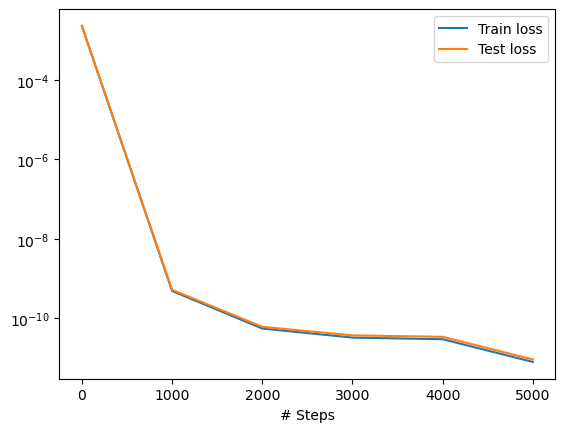

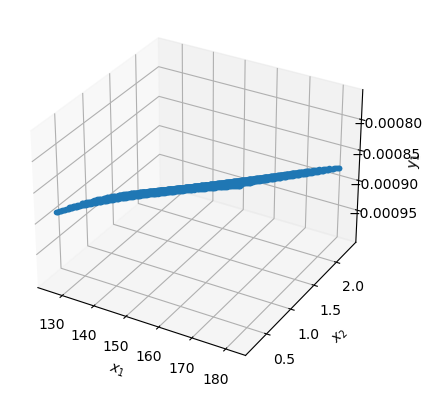

In [66]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)